### Load packages

In [ ]:
# Allow libraries to change without having to restart kernel
%reload_ext autoreload
%autoreload 2

In [ ]:
import hypergraphx as hgx
import networkx as nx
import pickle as pk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import time
import datetime
import os


### Set Root

In [ ]:
ROOT = 'put_personal_root_dir_here/{ds}'

## Reading the raw data into a more usable format

In [ ]:
ds = 'FnF'
root = ROOT.format(ds=ds)

if not os.path.isfile(f'{root}/fnf_processed.pck'):
    print("Not yet loaded and saved")

    person1_list = []
    person2_list = []
    time_list = []
    data_name = f"{root}/BluetoothProximity.csv"
    file = open(data_name, "r")
    next(file) # skip first line 
    for line in file:
        # print(line)
        row = line.split(',')
        if row[2] and row[0]:
            person1_list.append(row[0])
            person2_list.append(row[2])
            ts = time.mktime(datetime.datetime.strptime(row[1], "%Y-%m-%d %H:%M:%S").timetuple()) # convert to timestamp
            time_list.append(int(np.round(float(ts))))
    file.close()

    unique_persons = list(set(person1_list).union(set(person2_list)))
    unique_pids = {old:new for new, old in enumerate(unique_persons)}

    person1_list_new = [unique_pids[p] for p in person1_list]
    person2_list_new = [unique_pids[p] for p in person2_list]

    f_n_f = np.array([time_list, person1_list_new, person2_list_new])
    pk.dump(f_n_f, open(f'{root}/fnf_processed.pck','wb'))

else:
    print("Already loaded and saved!")
    time_list, person1_list_new, person2_list_new = pk.load(open(f'{root}/fnf_processed.pck','rb'))


Already loaded and saved!


In [3]:
data = {'date':time_list, 'ID':list(zip(person1_list_new, person2_list_new))}
df = pd.DataFrame(data)

# data = {'date':time_list, 'ID1':person1_list_new, 'ID2':person2_list_new}
# df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'], unit='s')

# Create year-month and year-month-day columns
df['ym'] = df['date'].dt.to_period('M')  # Year-month
df['ymd'] = df['date'].dt.to_period('D')  # Year-month-day

df['rt_12h'] = df['date'].dt.round('12h')
df['rt_6h'] = df['date'].dt.round('6h')
df['rt_3h'] = df['date'].dt.round('3h')
df['rt_2h'] = df['date'].dt.round('2h')
df['rt_1h'] = df['date'].dt.round('1h')
df['rt_30m'] = df['date'].dt.round('30min') 
df['rt_15m'] = df['date'].dt.round('15min') 
df['rt_5m'] = df['date'].dt.round('5min')

df.head(5)

,date,ID,ym,ymd,rt_12h,rt_6h,rt_3h,rt_2h,rt_1h,rt_30m,rt_15m,rt_5m
0,2010-01-01 15:53:43,"(35, 87)",2010-01,2010-01-01,2010-01-01 12:00:00,2010-01-01 18:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 15:55:00
1,2010-01-01 15:53:43,"(35, 125)",2010-01,2010-01-01,2010-01-01 12:00:00,2010-01-01 18:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 15:55:00
2,2010-01-01 15:53:43,"(35, 43)",2010-01,2010-01-01,2010-01-01 12:00:00,2010-01-01 18:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 15:55:00
3,2010-01-01 16:08:42,"(35, 125)",2010-01,2010-01-01,2010-01-01 12:00:00,2010-01-01 18:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:15:00,2010-01-01 16:10:00
4,2010-01-01 16:08:42,"(35, 43)",2010-01,2010-01-01,2010-01-01 12:00:00,2010-01-01 18:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:15:00,2010-01-01 16:10:00


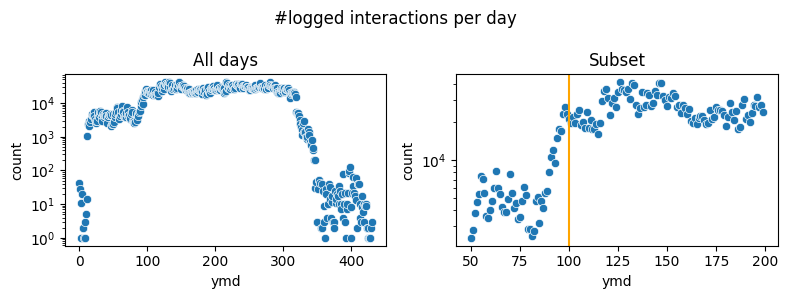

In [4]:
regime = 'ymd'
grouped = df.groupby(regime).size().reset_index(name='count')
grouped.head()
fig, ax = plt.subplots(1,2,figsize=(8,3))
sns.scatterplot(data=grouped, x=grouped.index, y='count', ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_xlabel(regime)
ax[0].set_title('All days')

start, end = [50, 200]

sns.scatterplot(data=grouped.iloc[start:end], x=grouped.iloc[start:end].index, y='count', ax=ax[1])
ax[1].set_xlabel(regime)
ax[1].axvline(x=100, color='orange')
ax[1].set_title('Subset')
ax[1].set_yscale('log')

plt.suptitle("#logged interactions per day")
plt.tight_layout()


## Plotting proportional size of lcc as function of size of aggregation window

In [5]:
aggregation_windows = ['rt_12h', 'rt_6h', 'rt_3h', 'rt_2h', 'rt_1h', 'rt_30m', 'rt_15m']

days = ['2010-10-19',  '2010-10-20', '2010-10-21', '2010-10-22', '2010-10-23']

index = ['hyperedges', 'max-edge-size', 'num_ho_cc', 'num_g_cc', 'diff_in_comps' ,'size_LCC_max', 'avg_k_LCC']  #, 'avg_k_centrality_LCC'

### Starting at 12h for different days

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

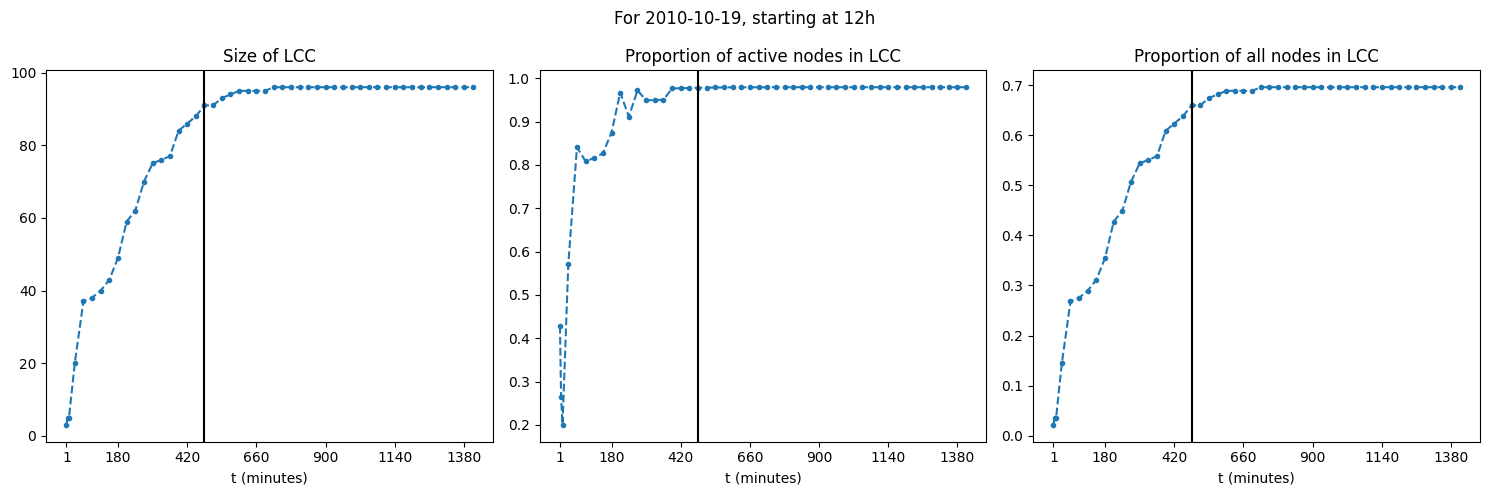

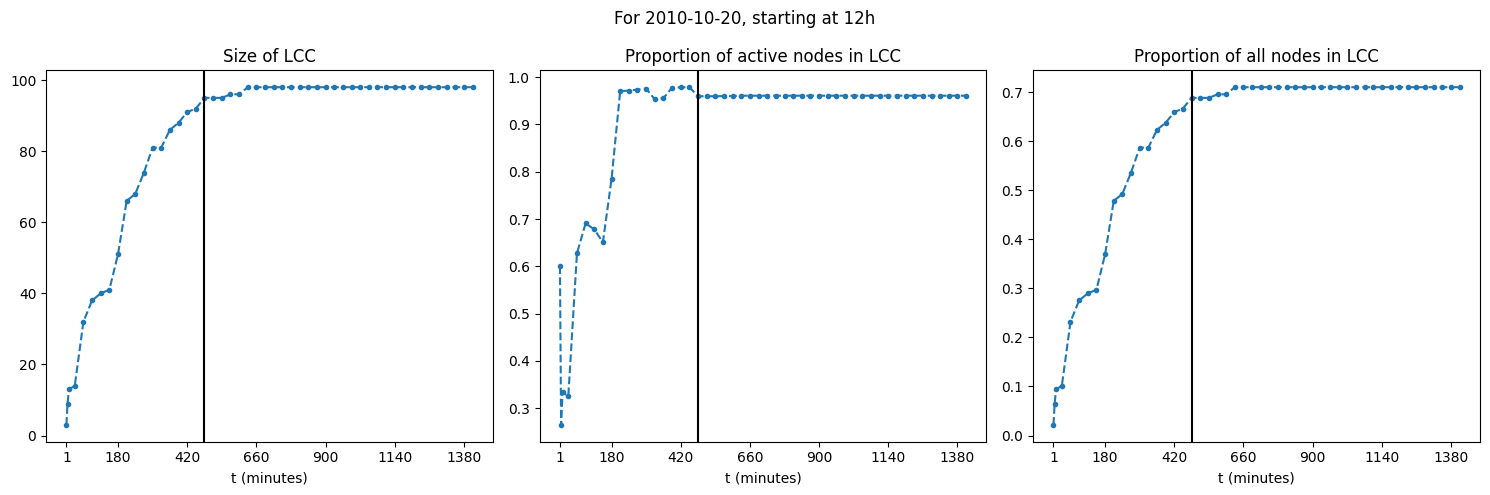

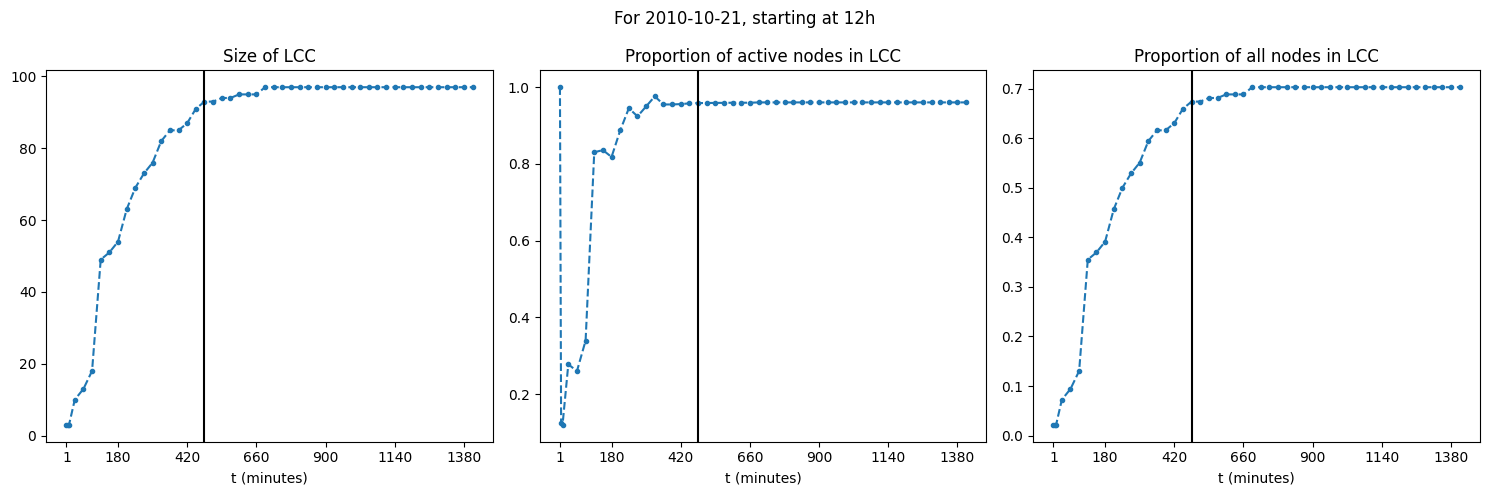

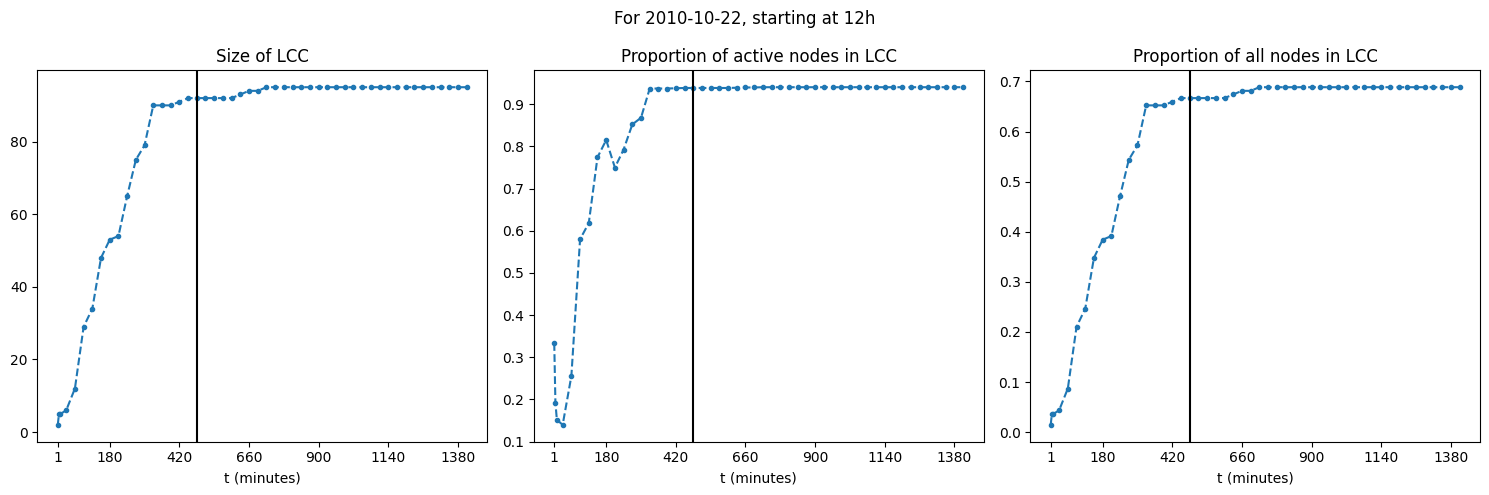

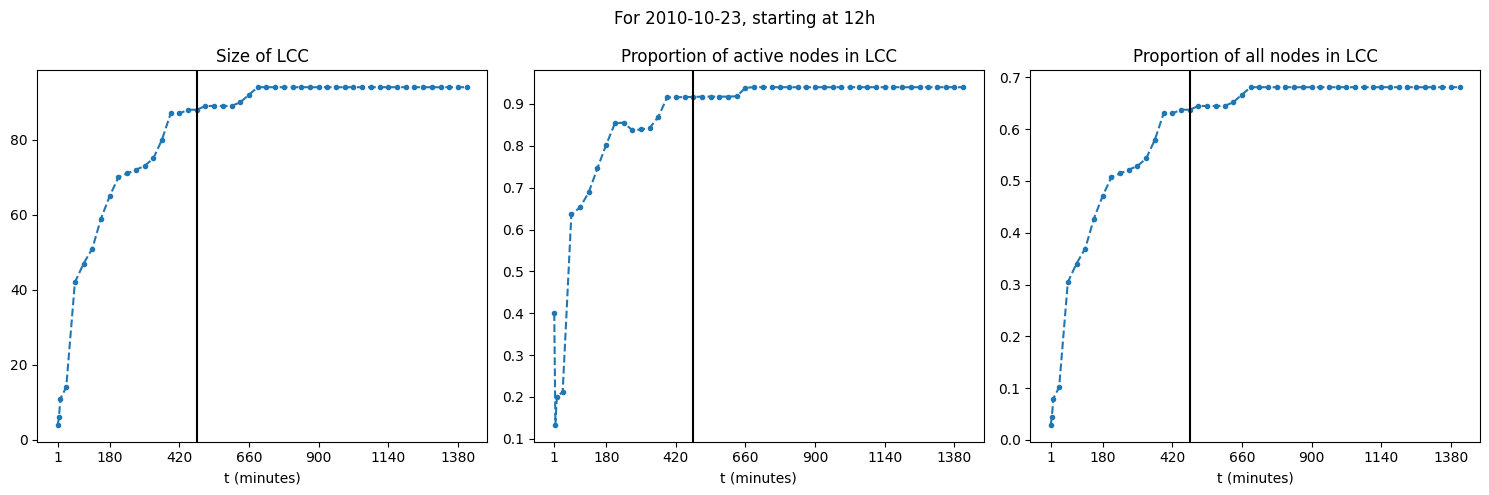

In [6]:
for day in days:

    sel_df = df[df['ymd']==day][['date', 'ID']]
    
    start_point = pd.Timestamp(f'{day} 12:00:00')

    delta_minutes = [1, 5, 10] + list(range(30, 60*24, 30))

    active_lcc_prop = []
    total_lcc_prop = []
    lcc_size = []

    for min in tqdm(delta_minutes):
        print(f"{min} minutes", end='\r')
        time_delta = pd.Timedelta(minutes=min)

        # Define the time range (start to start + time_delta)
        start_range = start_point
        end_range = start_point + time_delta

        # Filter the DataFrame to include only rows within the time range
        delta_t_df = sel_df[(sel_df['date'] >= start_range) & (sel_df['date'] <= end_range)]

        elist = delta_t_df['ID'].tolist()
        G_ = nx.Graph(elist)
        cliques = list(nx.find_cliques(G_))
        # print(len(cliques))
        H_ = hgx.Hypergraph(list(nx.find_cliques(G_)))
        dyad_G_ = nx.Graph((H_.get_edges(size=2)))
        H_cc = list(H_.connected_components())
        # LCC_dyad = nx.subgraph(dyad_G_, max(nx.connected_components(dyad_G_), key=len))

        lcc_size.append(len(max(H_cc, key=len)))
        active_lcc_prop.append(lcc_size[-1] / H_.num_nodes())
        total_lcc_prop.append(lcc_size[-1] / 138)
        # print(f"{min}.\t|E|={H_.num_edges()}, \t|V|={H_.num_nodes()}, \t|LCC|={lcc_size[-1]:.4f}, \t|LCC|/|V_t|={active_lcc_prop[-1]:.4f} 't|LCC|/|V|={total_lcc_prop[-1]:.4f} \ttrans={nx.transitivity(dyad_G_):.4f} \ttrans_LCC={nx.transitivity(LCC_dyad):.4f}")


    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.plot(delta_minutes, lcc_size, '.--')
    plt.xticks(delta_minutes[::8])
    plt.xlabel(f"t (minutes)")
    plt.axvline(x=480, color='k')
    plt.title('Size of LCC')

    plt.subplot(132)
    plt.plot(delta_minutes, active_lcc_prop, '.--')
    plt.xticks(delta_minutes[::8])
    plt.axvline(x=480, color='k')
    plt.xlabel(f"t (minutes)")
    plt.title('Proportion of active nodes in LCC')

    plt.subplot(133)
    plt.plot(delta_minutes, total_lcc_prop, '.--')
    plt.xticks(delta_minutes[::8]);
    plt.title('Proportion of all nodes in LCC')
    plt.axvline(x=480, color='k')
    plt.suptitle(f"For {day}, starting at 12h")
    plt.xlabel(f"t (minutes)")
    plt.tight_layout()

### Different starting points in the same day

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

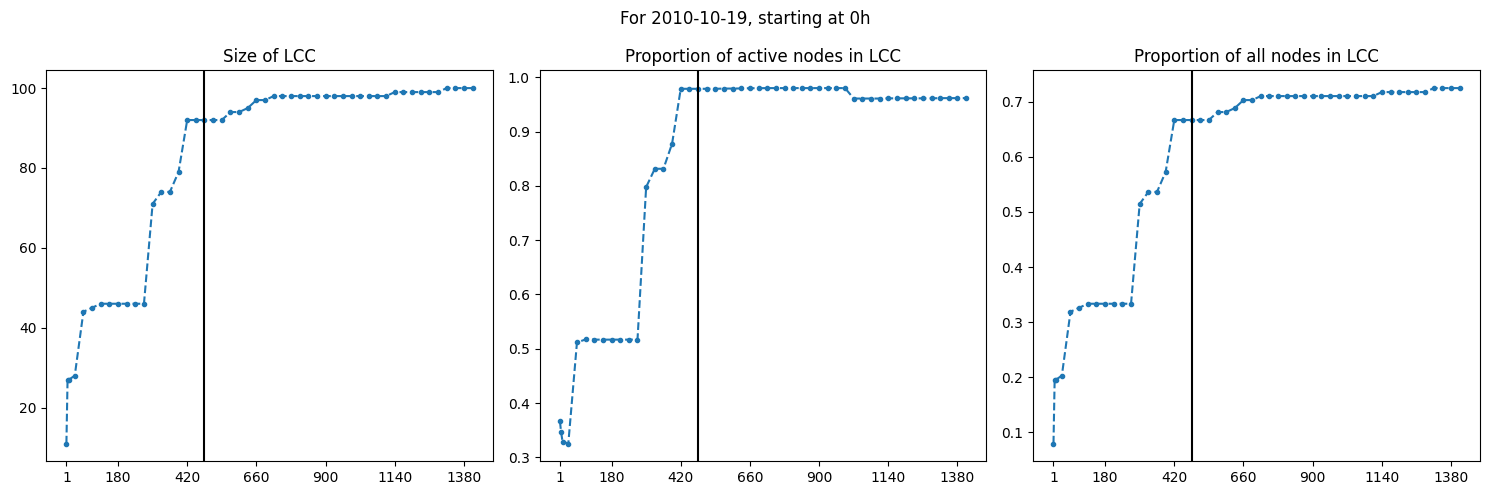

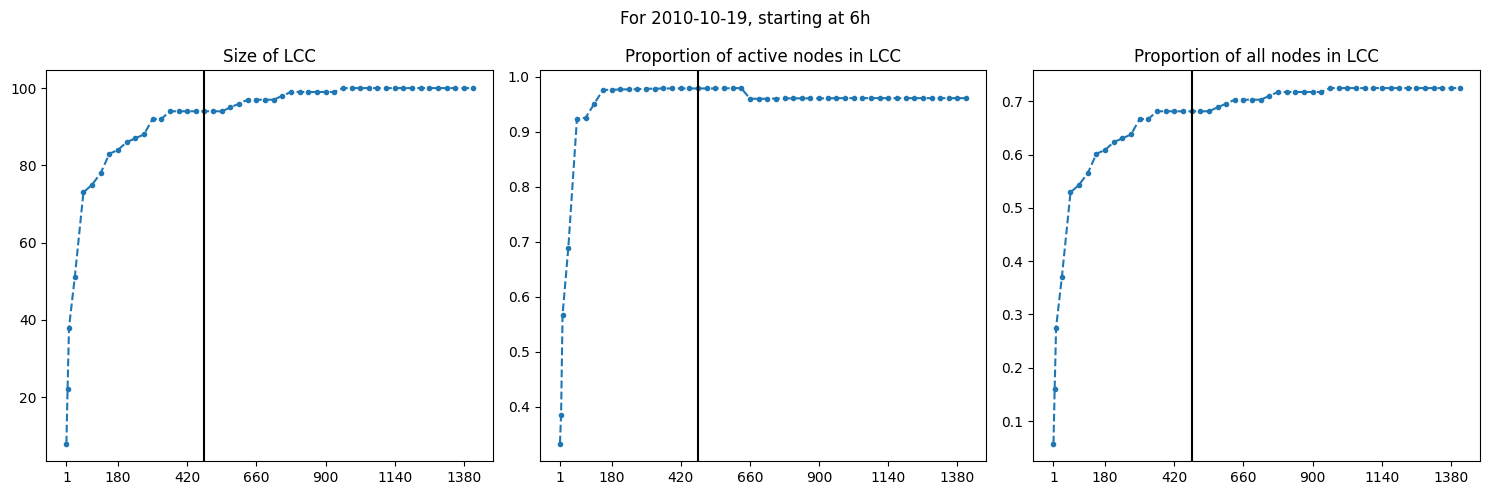

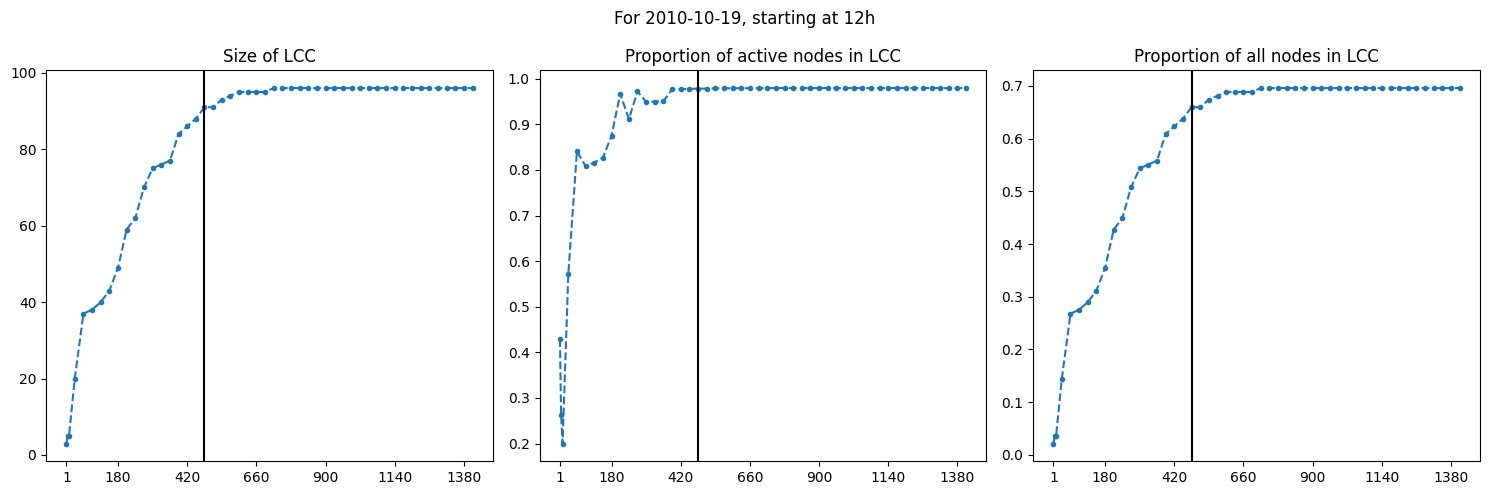

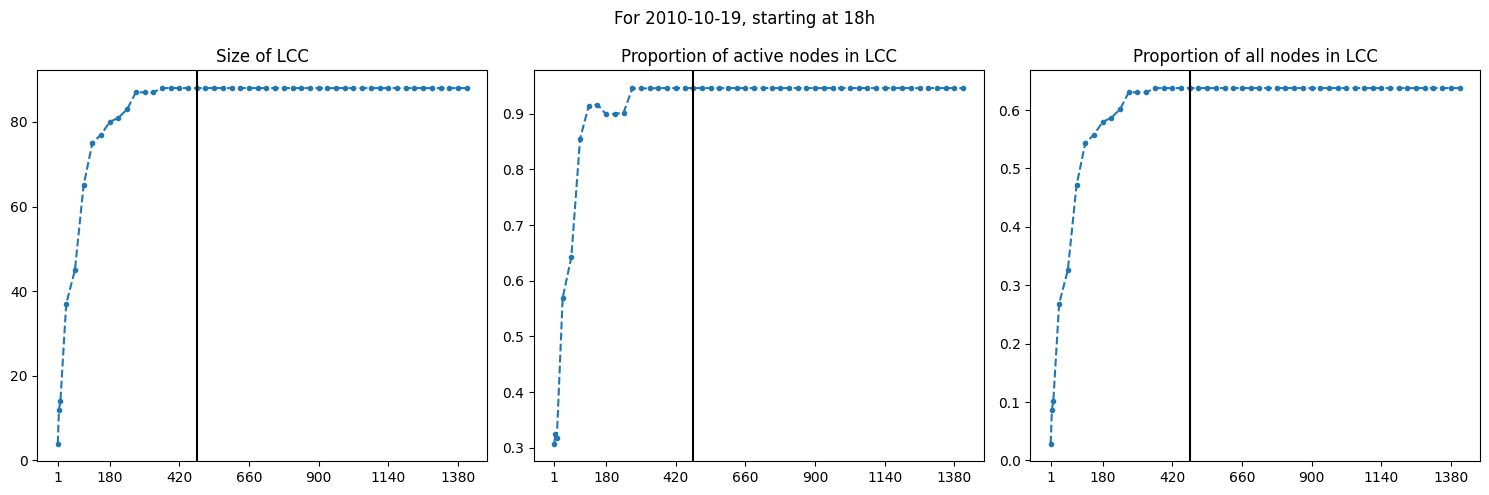

In [7]:
day = days[0]
sel_df = df[df['ymd']==day][['date', 'ID']]

for hour in ['00', '06', '12', '18']:

    start_point = pd.Timestamp(f'{day} {hour}:00:00')

    delta_minutes = [1, 5, 10] + list(range(30, 60*24, 30))

    active_lcc_prop = []
    total_lcc_prop = []
    lcc_size = []

    for min in tqdm(delta_minutes):
        print(f"{min} minutes", end='\r')
        time_delta = pd.Timedelta(minutes=min)

        # Define the time range (start to start + time_delta)
        start_range = start_point
        end_range = start_point + time_delta

        # Filter the DataFrame to include only rows within the time range
        delta_t_df = sel_df[(sel_df['date'] >= start_range) & (sel_df['date'] <= end_range)]

        elist = delta_t_df['ID'].tolist()
        G_ = nx.Graph(elist)
        cliques = list(nx.find_cliques(G_))
        # print(len(cliques))
        H_ = hgx.Hypergraph(list(nx.find_cliques(G_)))
        dyad_G_ = nx.Graph(H_.get_edges(size=2))
        H_cc = list(H_.connected_components())
        LCC_dyad = nx.subgraph(dyad_G_, max(nx.connected_components(dyad_G_), key=len))

        lcc_size.append(len(max(H_cc, key=len)))
        active_lcc_prop.append(lcc_size[-1] / H_.num_nodes())
        total_lcc_prop.append(lcc_size[-1] / 138)


    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.plot(delta_minutes, lcc_size, '.--')
    plt.xticks(delta_minutes[::8])
    plt.axvline(x=480, color='k')
    plt.title('Size of LCC')

    plt.subplot(132)
    plt.plot(delta_minutes, active_lcc_prop, '.--')
    plt.xticks(delta_minutes[::8])
    plt.axvline(x=480, color='k')
    plt.title('Proportion of active nodes in LCC')

    plt.subplot(133)
    plt.plot(delta_minutes, total_lcc_prop, '.--')
    plt.xticks(delta_minutes[::8]);
    plt.axvline(x=480, color='k')
    plt.title('Proportion of all nodes in LCC')
    plt.suptitle(f"For {day}, starting at {int(hour)}h")
    plt.tight_layout()

## Creating time series based on 8hr aggregation windows

We choose 8 hours as the smallest aggregation window size for which the LCC's size saturates. 

In [8]:
df.head(5)

,date,ID,ym,ymd,rt_12h,rt_6h,rt_3h,rt_2h,rt_1h,rt_30m,rt_15m,rt_5m
0,2010-01-01 15:53:43,"(35, 87)",2010-01,2010-01-01,2010-01-01 12:00:00,2010-01-01 18:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 15:55:00
1,2010-01-01 15:53:43,"(35, 125)",2010-01,2010-01-01,2010-01-01 12:00:00,2010-01-01 18:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 15:55:00
2,2010-01-01 15:53:43,"(35, 43)",2010-01,2010-01-01,2010-01-01 12:00:00,2010-01-01 18:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 15:55:00
3,2010-01-01 16:08:42,"(35, 125)",2010-01,2010-01-01,2010-01-01 12:00:00,2010-01-01 18:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:15:00,2010-01-01 16:10:00
4,2010-01-01 16:08:42,"(35, 43)",2010-01,2010-01-01,2010-01-01 12:00:00,2010-01-01 18:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:00:00,2010-01-01 16:15:00,2010-01-01 16:10:00


In [9]:
# for each month we create a separate dataset
unique_months = list(df['ym'].unique())
for month in unique_months:
    # for each day in the month, we group in slots of 8 hours
    unique_days_in_month = df[df['ym']==month]['ymd'].unique()
    print(month, len(unique_days_in_month))



2010-01 5
2010-07 16
2010-08 31
2010-09 30
2010-10 31
2010-11 30
2010-12 31
2011-01 31
2011-02 28
2011-03 31
2011-04 30
2011-05 31
2011-06 30
2011-07 20
2011-08 7
2011-09 14
2011-10 17
2011-11 7
2011-12 6
2012-03 4
2012-05 1


In [10]:
# SELECT MONTHS FOR WHICH WE HAVE FULL DATA
unique_months = unique_months[2:12]

In [11]:
# We break up into 8-hr blocks
hours = ['00', '08', '16']


TS_by_months = {}
for month in tqdm(unique_months):
    TS_month = {}

    unique_days_in_month = df[df['ym']==month]['ymd'].unique()
    for day in unique_days_in_month:
        for hour in hours:
            sel_df = df[df['ymd']==day][['date', 'ID']]

            start_point = pd.Timestamp(f'{day} {hour}:00:00')
            time_delta = pd.Timedelta(minutes=min)
            end_point = start_point + time_delta


            # Filter the DataFrame to include only rows within the time range
            delta_t_df = sel_df[(sel_df['date'] >= start_point) & (sel_df['date'] <= end_point)]

            elist = delta_t_df['ID'].tolist()
            G_ = nx.Graph(elist)
            cliques = list(nx.find_cliques(G_))
            H_ = hgx.Hypergraph(cliques)

            TS_month[f"{day}-{hour}h"] = H_
    
    TS_by_months[month] = TS_month
        


  0%|          | 0/10 [00:00<?, ?it/s]

## Saving the time-series

In [ ]:
for month in tqdm(unique_months):
    ds = f"FnF_{str(month)}"
    root = ROOT.format(ds=ds)
    TS_month = TS_by_months[month]
    pk.dump(TS_month, open(f"{root}/processed/TS_{ds}.pck", 'wb'), protocol=-1)